# Queue Management

* The queue is used to task labelers with specific examples
* We can do any of the following:
    * Set the number of times we want an image labeled
        * Referred to as `Consensus` in the front end
    * Set the order of items in the queue
    * Set the percent of assets to review

In [3]:
from labelbox import Client, Project, Dataset, LabelingFrontend
from labelbox.schema.ontology import OntologyBuilder
import numpy as np
from PIL import Image, ImageDraw,ImageFont
from io import BytesIO

### Set up demo project

In [4]:
#We are going to create a new project for this
#Checkout the project_setup notebook for more details on this cell.
client = Client()
project = client.create_project(name = "queue_project")
dataset = client.create_dataset(name = "queue_dataset")
editor = next(client.get_labeling_frontends(where = LabelingFrontend.name == 'editor'))
project.setup(editor, OntologyBuilder().asdict()) #empty ontology since we aren't actually labeling..
project.datasets.connect(dataset)

In [5]:
def make_digit_image(digit):
    font = ImageFont.truetype("Verdana.ttf",128)
    img = Image.fromarray(np.zeros((500,500,3), dtype = np.uint8))
    draw = ImageDraw.Draw(img)
    draw.text((200, 180), str(digit), font = font)
    return img

In [8]:
#Ok so lets add these to the project
for idx in range(15):
    img = make_digit_image(idx + 1)
    img_bytes = BytesIO()
    img.save(img_bytes, format = "jpeg")
    row_data = client.upload_data(img_bytes.getvalue(), content_type ='image/jpeg')
    dataset.create_data_row(row_data=row_data,external_id = f"queue_{idx + 1}")

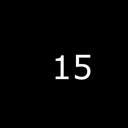

In [26]:
#Example image
img.resize((128,128))

# Set Queue Order

In [10]:
data_rows = list(dataset.data_rows())
#project.set_labeling_parameter_overrides(data)

In [11]:
priorities = []
for data_row in data_rows:
    priorities.append(
        (data_row, int(data_row.external_id.split('_')[-1]), 1)
    )

In [12]:
#Ordered by external_id
for priority in priorities:
    print(priority)

(<DataRow ID: ckmdk068i0a100z8zer957sig>, 1, 1)
(<DataRow ID: ckmdk071z098u0y9geqsk00on>, 2, 1)
(<DataRow ID: ckmdk07sf084r0yaxczz02glq>, 3, 1)
(<DataRow ID: ckmdk08ff0a1e0z8z4sjnfrph>, 4, 1)
(<DataRow ID: ckmdk08yy0djc0y829kizfmye>, 5, 1)
(<DataRow ID: ckmdk09vk09lx0y7g15ti1qrp>, 6, 1)
(<DataRow ID: ckmdk0aj0085f0yaxhx8g6bi3>, 7, 1)
(<DataRow ID: ckmdk0b2g099h0y9gezcu9bzx>, 8, 1)
(<DataRow ID: ckmdk0bp1099n0y9gbgznhvod>, 9, 1)
(<DataRow ID: ckmdk0dgj0a2d0z8z0uu6dr5e>, 10, 1)
(<DataRow ID: ckmdk0e2e09mk0y7gdadngi7v>, 11, 1)
(<DataRow ID: ckmdk0es60dk60y82d7zg7qpc>, 12, 1)
(<DataRow ID: ckmdk0fhq09a90y9gbgfq1zz5>, 13, 1)
(<DataRow ID: ckmdk0fzs08620yaxfwd8cd1c>, 14, 1)
(<DataRow ID: ckmdk0gq00dkr0y82edsy8o3f>, 15, 1)


In [13]:
project.set_labeling_parameter_overrides(priorities)

True

In [19]:
#Go to your project and you should see the numbers appear in order.

True

### Set number of duplicates
* Here we set a duplicate of 2.
* If you have two accounts to log into the project from, both users will get the same 15 images in order.
* Even from one account you will see it works by skipping a single image and then go to the project overview
    * You will see 29 remaining with 1 skipped (15 images 2 copies of each).

In [21]:
#Images will still be labeled in the same order (determined by p[1])
#But now each image will be labeled 2 times (never by the same user. 
#(If you don't have at least 3 users the items will remain in the queue.)
duplicate_priorities = [(p[0], p[1], 2) for p in priorities]
project.set_labeling_parameter_overrides(duplicate_priorities)

True

### Remove Queue Order
* This will delete all of the priorities
* Duplicates in the queue will also be cleared

In [22]:
project.unset_labeling_parameter_overrides(data_rows)

True

* Go to the project and you will see 14 remaining with 1 skipped (was 29.)

### Review Queue
* Set the percent of labels to be reviewed 

In [25]:
#You can set the percent of labels to be sent to the review queue by running 
#Can be 0 to 1 representing 0 to 100%
project.upsert_review_queue(0.2)

* Go to the project at the bottom you will see the `training data quality` section.
* Coverage should be 20%